# Setup

## Imports

In [1]:
from typing import Callable, Literal

from dataclasses import dataclass
import einops
from jaxtyping import Float
import numpy as np
import torch as t
from torch import Tensor, nn
from torch.nn import functional as F
from tqdm.auto import tqdm

from C1_plotly_utils import line, imshow
import C1P3_1_tests as tests
import C1P3_1_utils as utils

## Set device

In [2]:
device = t.device(
    "mps"
    if t.backends.mps.is_available()
    else "cuda"
    if t.cuda.is_available()
    else "cpu"
)
print(device)

cuda


# Superposition & Sparse Autoencoders

## Introduction

Superposition is a crucial concept for understanding how transformers work.

**Superposition is when a model represents more than $n$ features in $n$-dimensional activation space. I.e., features still correspond to directions, but the *set of interpretable directions is larger than the number of dimensions***

Why would this happen?
- In general, its almost certain that the world contains vastly more features then the model has dimensions of freedom, and so it's impossible to have a 1-1 mapping between features and values in the model.

- The model has to represent features *somehow*. To do this, it comes up with techniques for cramming multiple features into fewer dimensions at the cost of adding noise and interference between features.

**Note:**
- There's quite a bit of theory that needs to be understood before one can start making inferences from the results of our coding experiments.

- Key point: we really don't understand superposition well.

- It's hard to point to a seminal work in this field because we don't really know what the critical new insights will look like.

## Content & Learning Objectives

### Sections 1, 2, 3: Toy Models of Superposition: basics

- Understand the concept of superposition, and why models need to do it.

- Understand the difference between superposition and polysemanticity

- Understand the difference between a neuron and bottleneck superposition
  - Computational versus representational superposition.

- See how superposition varies when you alter:
  - Importance

  - Sparsity

  - Correlation

### Section 4: Feature Geometry

- Understand the geometric intuitions behind superposition and how they relate to the more general ideas of superposition in larger models.

### Section 5: Sparse Autoencoders in Toy Models

- Learn about sparse autoencoders and how they can be used to disentangle features represented in superposition.

- Train your own SAEs on the toy models from earlier sections, and visualise the feature reconstruction process.

- Understand important SAE training strategies, such as resampling, as well as architecture variants, such as Gated or Jump ReLU.

### Bonus

- Suggested extra material

- Paper replications

## Reading Material

- [200 Concrete Open Problems in Mechanistic Interpretability: Exploring Polysemanticity and Superposition](https://www.alignmentforum.org/posts/o6ptPu7arZrqRCxyz/200-cop-in-mi-exploring-polysemanticity-and-superposition), **15 min**
  - Up to and including "Tips"

- Neel Nanda's [Dynalist notes on superposition](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=3br1psLRIjQCOv2T4RN3V6F2), **10 min**
  - Use as a reference for the exercises.

- Anthropic's [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html), **20 min**
  - Read up to and including *"Summary, A Hierarchy of Feature Properties"*

  - The first few sections: *"Key Results"*, *"Definitions and Motivation"*, and *"Empirical Phenomena"* are particular important.

## Questions:

#### What is a **privileged basis**?
- A basis where the *standard basis directions are meaningful* due to the structure of the computation being performed on that basis. It doesn't necessarily mean the basis is interpretable!

- Consider *neurons*:
  - Neuron activations are privileged because of the *elementwise nonlinear function that gets applied*. $\text{ReLU}$ is easily described in the standard basis. E.g. in 2D:

    $$
    \begin{bmatrix}
    x \\
    y
    \end{bmatrix}
    \rightarrow
    \begin{bmatrix}
    \max{(x, 0)} \\
    \max{(y, 0)}
    \end{bmatrix}
    $$

    But if you redefine a basis $x'=(x+y)/\sqrt{2},\;y'=(x-y)/\sqrt{2}$, then describing $\text{ReLU}$ in this new basis becomes messy. Importantly, we now get *interference* between the components $x'$ and $y'$. $\text{ReLU}$ is no longer acting on them independently.

    $$
    \begin{bmatrix}
    x' \\
    y'
    \end{bmatrix}
    \rightarrow
    \frac{1}{\sqrt{2}}
    \begin{bmatrix}
    \max(x, 0)+\max(y, 0) \\
    \max(x, 0)-\max(y, 0)
    \end{bmatrix}
    =
    \frac{1}{2}
    \begin{bmatrix}
    \max(x'+y', 0)+\max(x'-y', 0) \\
    \max(x'+y', 0)-\max(x'-y', 0)
    \end{bmatrix}
    $$

- Consider the *residual stream*:
  - The residual stream is *not* privileged because anything that reads from it and writes to it uses a *linear map*.

  - If we changed
    - all the writing matrices, i.e., $W_{out}$ in the MLP layers and $W_O$ in the attention laters, to $W \rightarrow WR$,
    - and all the reading matrices, i.e., $W_{in}$ in the MLP layers and $W_Q$, $W_K$, $W_V$ in the attention layers,  to $W \rightarrow W R^{-1}$

    where $R$ is some arbitrary rotation matrix, then the model's computation would be unchanged. Since $R$ can change the basis arbitrarily, the basis cannot be privileged.

**A basis is privileged if it is not rotation-independent.** The nature of the computation performed on it means that the basis directions have some special significance.

**A privileged basis is NOT equivalent to an interpretable basis**.
  - It is true that a basis must be privileged if the individual basis directions have some interpretable meaning, but this is merely *necessary*, not *sufficient*.

#### What is the difference between **superposition** and **polysemanticity**?
- Polysemanticity is a characteristic of a neuron where its activation corresponds to multiple features.
  - A monosemantic neuron's activation corresponds to a single feature. This is fuzzy: if a neuron activates strongly for one feature and weakly for others, it may still be reasonable to consider it to be monosemantic. 


- Superposition (more features than dimensions/neurons) implies polysemanticity, *but not the other way around*:
  - Polysemanticity only implies that the *standard* basis is uninterpretable. There could still be an interpretable basis of features.

#### What are the **importance** and **sparsity** of features? Do you expect more or less polysemantic neurons if sparsity is greater?
- *Importance* measures how useful a feature is for achieving lower loss. More important features are more expensive to interfere with.

- *Sparsity* measures how frequently the feature is in the input. Controlling for importance, A sparser feature will interfere less with other features.

- We expect more polysemantic neurons for greater sparsity. This is because a single neuron can afford to represent more different sparse features. Usually it will only be representing one at a time, so interference is minimal. 

#### How would you define a feature?
Difficult. Some candidates:
- A property of an input to the model, or some subset of that input.

- A scalar function of the input; directions, and often simply individual neurons.
  - Claim: such featrues in neural networks are typically meaningful features that can be rigorously studied.

  - A meaningful feature is one that genuinely responds to an **articulable** property of the input, such as the presence of a curve or a floppy ear.

# Toy Models of Superposition: Superposition in a Nonprivileged Basis

## Toy Model setup

Following  Antropic's [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html) paper. Particularly from [Demonstrating Superposition](https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating) onwards.

Rudimentary model of **bottleneck superposition**: representing more than $n$ features in an $n$-dimensional vector space. Specifically:
- 5D input $x$

- Map down to 2D space

- Map back up to 5D space using transpose of first matrix/map

- Add a bias and ReLU

$$
h = Wx \\
x'=\text{ReLU}(W^Th + b)
$$

### Motivation for setup


The input $x$ represents 5 features uniformly sampled between 0 and 1.

Each feature can have **importance** and **sparsity**. This is realised in our toy model as follows:

- **Importance** = the coefficient on the weighted mean squared error between the input and the output, which we use for training the model.

  - I.e., our loss function is $L = \sum_x \sum_i I_i(x_i-x'_i)^2$, where $I_i$ is the importance of feature $i$

- **Sparsity** = the probability of the corresponding element in $x$ being zero.

  - I.e., this affects the way our training data is generated. See `generate_batch()` in `Module` below.

  - We often refer to **feature probability** = 1 - sparsity, rather than sparsity.

#### Justification for using $W^TW$:

- $W$ (shape `(2, 5)`) can be thought of as a grid of "overlap values" between the features and bottleneck dimensions.

- The values of $W^TW$ are the dot products between the 2D representations of each pair of features.

- If each of $W$'s columns were unit vectors, then $W^TW$ would be a matrix of cosine similarities between the features.
  - With diagonal elements equal to 1, since the similarity of a feature with itself is 1.

  - See below for an illustration:

In [3]:
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

imshow(
    W_normed.T @ W_normed,
    title="W^T W, the cosine similarities of each pair of 2D feature embeddings",
    width=600,
)

If the columns of $W$ were orthogonal, then $W^TW$ would be the identity. This is impossible because $W$ is a $2\times5$ matrix, but its columns can be *nearly* orthogonal. I.e., having cosine similarities close to 0.

#### Proof that $W^TW$ cannot be the identity when $W$ is not a square matrix.

The rank of a matrix product $AB$ cannot exceed the rank of either of the factors $A$ and $B$. In the case of $W^TW$, both $W^T$ and $W$ have rank at most $2$, so $W^TW$ has rank at most $2$.

#### Another way to visualise:

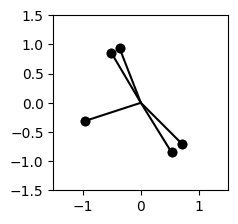

In [4]:
utils.plot_features_in_2d(W_normed)

##### Interpretation

- $W$ can be viewed as a set of five 2D vectors, one for each of our five features. The heatmap shows us the cosine similarities between each pair of these vectors, and the second plot shows us these five vectors in 2D space.

- Note that two pairs of vectors (the 1st & 2nd, and the 0th & 4th) have very high cosine similarity. This is reflected in the 2D plot, where these features are very close to each other.

### Defining our model

#### Weights & instances

The `Config` class has an `n_inst` class. This permits optimisation of multiple models at once in a single training loop. It can be treated like a batch dimension for weights: each of the weights/biases will actually be `n_inst` separate weights/biases stacked along the zeroth dimension, each of which will be trained independently, on different data, in parallel, using the same optimiser.

We initialise weights `W` and `b_final`, corresponding $W$ and $b$ in the Anthropic paper.

#### Feature probability and sparsity

- The `feature_probability` and `importance` arguments correspond to sparsity and importance of features.

- Remember, `feature_probability = 1 - sparsity`. Easier to refer to feature probability.

- Will often deal with very small values $p = 1 - S \approx 0$.

- The feature probability is used to generate training data. The importance is used in our loss function. Default is `feature_probability = None`, meaning $p = 1$, or no sparsity.

- The `importance` argument is used when calculating loss. Default is uniform importance.

- `__init__()` includes code to broadcast `feature_probability` and `importance`, so that they always have shape `(n_inst, n_features)`

### Exercise: implement `forward`

In [5]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_inst models in a single training loop to let us sweep over sparsity or importance
    # curves efficiently. You should treat the number of instances `n_inst` like a batch dimension,
    # but one which is built into our training setup. Ignore the latter 3 arguments for now, they'll
    # return in later exercises.
    n_inst: int
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal["unif", "jump"] = "unif"


class Model(nn.Module):
    W: Float[Tensor, "inst d_hidden feats"]
    b_final: Float[Tensor, "inst feats"]

    # Our linear map (for a single instance) is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: float | Tensor = 0.01,
        importance: float | Tensor = 1.0,
        device=device,
    ):
        super(Model, self).__init__()
        self.cfg = cfg

        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to(
            (cfg.n_inst, cfg.n_features)
        )
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to(
            (cfg.n_inst, cfg.n_features)
        )

        self.W = nn.Parameter(
            nn.init.xavier_normal_(t.empty((cfg.n_inst, cfg.d_hidden, cfg.n_features)))
        )
        self.b_final = nn.Parameter(t.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)

    def forward(
        self,
        features: Float[Tensor, "... inst feats"],
    ) -> Float[Tensor, "... inst feats"]:
        h = einops.einsum(
            features, self.W, "... inst feats, inst d_hidden feats -> ... inst d_hidden"
        )

        return F.relu(
            einops.einsum(
                h, self.W, "... inst d_hidden, inst d_hidden feats -> ... inst feats"
            )
            + self.b_final
        )

    def generate_batch(self, batch_size) -> Float[Tensor, "batch inst feats"]:
        """
        Generates a batch of data.
        """
        shape = (batch_size, self.cfg.n_inst, self.cfg.n_features)
        feats = t.rand(shape, device=self.W.device)
        feat_seeds = t.rand(shape, device=self.W.device)
        feats[feat_seeds > self.feature_probability] = 0.0

        return feats

    def calculate_loss(
        self,
        out: Float[Tensor, "batch inst feats"],
        batch: Float[Tensor, "batch inst feats"],
    ) -> Float[Tensor, ""]:
        """
        Calculates the loss for a given batch (as a scalar tensor), using this loss described in the
        Toy Models of Superposition paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Note, `self.importance` is guaranteed to broadcast with the shape of `out` and `batch`.
        """

        return (self.importance * (out - batch) ** 2).mean(dim=(0, 2)).sum()

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_inst, lr=step_lr)


tests.test_model(Model)

C:\Users\matth\AppData\Local\Temp\ipykernel_56460\4258332681.py:45: UserWarning:

expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)



All tests in `test_model` passed!


### Exercise: implement `generate batch` (above)

Returns a tensor of shape `(n_batch, instances, featrues)`, where:

- `instances` and `features` values are taken from the model's config.

- Each feature is present with probability `self.feature_probability`.

- For each present feature, its **magnitude** is sampled from a uniform distribution between 0 and 1.

In [6]:
tests.test_generate_batch(Model)

All tests in `test_generate_batch` passed!


## Training our model

### Exercise: implement `calculate_loss`

The loss function for a **single instance** is given by:

$$
L = \frac{1}{BF}\sum_x \sum_i I_i(x_i - x'_i)^2
$$

where:
- $B$ is the batch size
- $F$ is the number of features
- $x_i$ are the inputs and $x'_i$ are the model's outputs
- $I_i$ is the importance of feature $i$
- $\sum_i$ is a sum over features 
- $\sum_x$ is a sum over elements in the batch

For the general case, we sum this formula over all instances.

#### Why average over the feature and batch dimensions, but sum over the instances dimension?

- Mean over batch size is standard for loss functions; it means we don't have to use a difference learning rate for different batch sizes.

- Mean over features is [normal for mean squared-error loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

- Sum over instances in order to train each instance independently, and at the same rate as we would a single instance.

In [7]:
tests.test_calculate_loss(Model)

All tests in `test_calculate_loss` passed!


### Reproducing and interpreting a figure in the Anthropic paper's Introduction

**Notes**:
- The `importance` argument is the sames for all instances. It takes values between $1$ and $~0.66$ for each feature. So, for every instance, there will be some features more important than others.

- The `feature_probability` is the same for all features, but varies across instances. I.e., this runs several experiments at once, comparing the effect of having larger feature sparsity.

In [14]:
cfg = Config(n_inst=8, n_features=5, d_hidden=2)

# Importance varies within features for each instance.
importance = 0.9 ** t.arange(cfg.n_features)

feature_probability = 50 ** -t.linspace(0, 1, cfg.n_inst)

line(
    importance,
    width=600,
    height=400,
    title="Importance of each feature (same over all instances)",
    labels={"y": "Feature importance", "x": "Feature"},
)
line(
    feature_probability,
    width=600,
    height=400,
    title="Feature probability (varied over instances)",
    labels={"y": "Probability", "x": "Instance"},
)

Training our model

  0%|          | 0/10000 [00:00<?, ?it/s]

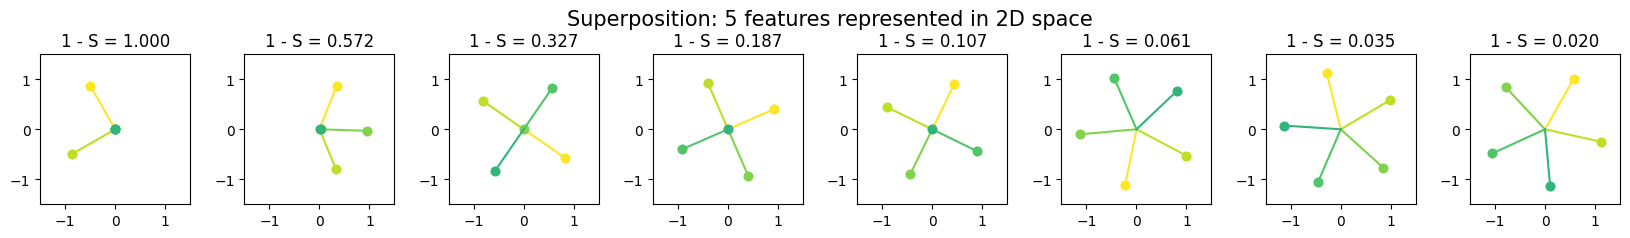

In [15]:
model = Model(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)
model.optimize(steps=10_000)

utils.plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1 - S = {fp:.3f}" for fp in feature_probability],
)

#### Interpretation

- With **no sparsity**, the model can never represent more than two features faithfully, so it ends up representing the two most important features (lighter colors in the plots).
  - It stores these orthogonally in 2D space, and sets the other 3 features to zero.

  - It can thus reconstruct the two most important features perfectly, but ignores the rest.

- With **high sparsity**, we get a pentagonal structure. Interference between features is minimal since most of the time, only one of the five features are active.
  - During feature recovery, we:
    - projecting our point in 2D space onto these five directions
    - can be confident that our projection onto the $i$-th feature direction only captures this feature (most of the time), rather than being affected by the presence of other features.

**Key idea**: two forces are competing:
  - *feature benefit*: representing more features is good
  - *interference&: representing things non-orthogonally is bad

The higher the sparsity, the more that the negative impact of interference is mitigated, and the trade-off shifts more towards "represent more features non-orthogonally"

### Visualising a batch's embedding

See that in the plots with high sparsity (to the right) very rarely have interference between the five features, because most often $\le 1$ of those features is present and the model can recover it by projecting along the corresponding feature dimension without losing any information.

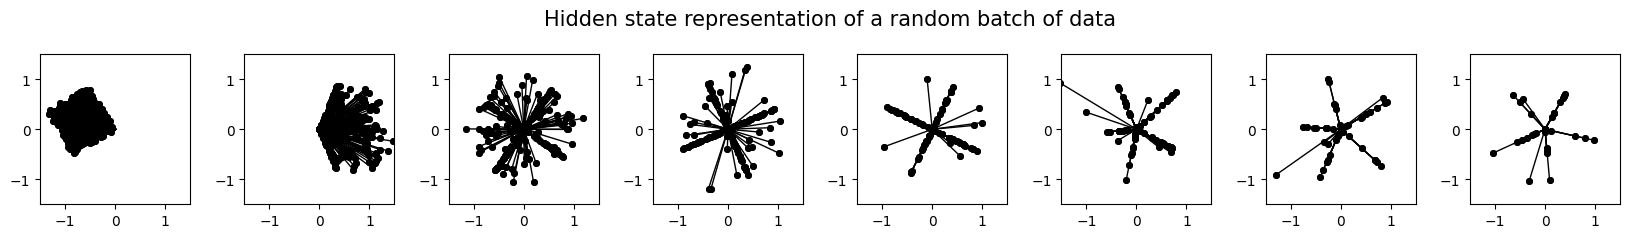

In [16]:
with t.inference_mode():
    batch = model.generate_batch(250)
    h = einops.einsum(
        batch, model.W, "batch inst feats, inst hidden feats -> inst hidden batch"
    )

utils.plot_features_in_2d(
    h, title="Hidden state representation of a random batch of data"
)